In [140]:
import os
import re
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(1)

In [153]:
def load_data(path="../train.tsv", length=2000):
    df = pd.read_csv(path, sep="\t")[:length]
    df.drop(['PhraseId','SentenceId'], axis=1, inplace=True)
    x, y = df["Phrase"].values, df["Sentiment"].values
    return (x, y)

x, y = load_data("../train.tsv")

def clean_text(x, y):
  # Removes special symbols and just keep
  # words in lower or upper form
  
  x = [i.lower() for i in x]
  x = [re.sub(r'[^A-Za-z]+', ' ', i) for i in x]
  x_, y_ = [], []
  for i in range(len(x)):
    if x[i].split():
      x_.append(x[i])
      y_.append(y[i])
  return x_, y_

x, y = clean_text(x, y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

print(len(x), len(x_train), len(y_train))
print(x[:5], y[:5])

1986 1588 1588
['a series of escapades demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amounts to much of a story ', 'a series of escapades demonstrating the adage that what is good for the goose', 'a series', 'a', 'series'] [1, 2, 2, 2, 2]


In [154]:
def build_dict(x):
    ret = []
    for i in x:
        ret += [j for j in i.split()]
    return list(set(ret))

d = build_dict(x)

word2inx = {d[i]:i for i in range(len(d))}

vocab_size = len(word2inx)

n_classes = 5

print(len(word2inx))

677


In [155]:
def sentence2vector(sentence):
    v = []
    for word in sentence.split():
        v.append(word2inx[word])
    return torch.tensor(v, dtype=torch.long)

"""
def sentiment2target(sentiment):
    tmp = torch.zeros(n_classes)
    tmp[sentiment] += 1
    return tmp
"""

test_input = sentence2vector(x[0])
#test_target = sentiment2target(y[0])
test_target = torch.tensor(y[0], dtype=torch.long)

print(test_input, test_target)

def get_batch(x, batch_size=2, point=0):
    return  [sentence2vector(i) for i in x[point:point+batch_size]]

test_batch = get_batch(x)

print(test_batch)


tensor([ 22, 108, 619, 444, 349, 273, 167, 464, 307,  39,  58, 662, 273, 348,
         39, 270,  58, 662, 273, 106,  59, 619, 117, 636, 659, 638, 599, 619,
        117, 663,  53, 641, 619,  22, 482]) tensor(1)
[tensor([ 22, 108, 619, 444, 349, 273, 167, 464, 307,  39,  58, 662, 273, 348,
         39, 270,  58, 662, 273, 106,  59, 619, 117, 636, 659, 638, 599, 619,
        117, 663,  53, 641, 619,  22, 482]), tensor([ 22, 108, 619, 444, 349, 273, 167, 464, 307,  39,  58, 662, 273, 348])]


In [156]:
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        self.hidden2tag = nn.Linear(hidden_dim, target_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        y_ = self.hidden2tag(lstm_out.view(len(sentence), -1))
        predict = F.log_softmax(y_, dim=1)
        return predict

loss_function = nn.NLLLoss()

optimizer = optim.SGD(net.parameters(), lr=0.1)

net = LSTM(100, 100, vocab_size, n_classes)

prob = net(test_input)

print(prob[-1].unsqueeze(0), test_target)

loss = loss_function(prob[-1].unsqueeze(0), test_target.unsqueeze(0))

loss.backward()

optimizer.step()

net.zero_grad()


tensor([[-1.5962, -1.7424, -1.5560, -1.6451, -1.5221]],
       grad_fn=<UnsqueezeBackward0>) tensor(1)


In [157]:
print(torch.argmax(prob[-1]))
print(x[37])
print(sentence2vector(x[37]))

tensor(4)
some of which occasionally amuses but none of which amounts to much of a story
tensor([ 59, 619, 117, 636, 659, 638, 599, 619, 117, 663,  53, 641, 619,  22,
        482])


epoch:  0 time:  5.390890121459961 loss:  1.5835163745986023
epoch:  1 time:  23.524370193481445 loss:  1.863969152745085
epoch:  2 time:  40.21370029449463 loss:  166.1689358409419
epoch:  3 time:  46.964521408081055 loss:  4.890846478145214
epoch:  4 time:  57.32571220397949 loss:  35.9148048684001
epoch:  5 time:  65.32982420921326 loss:  3.4982947635328046
epoch:  6 time:  73.62173628807068 loss:  3.0636318115284666e-05
epoch:  7 time:  85.56276512145996 loss:  12.356343901716173
epoch:  8 time:  92.68400120735168 loss:  2.2466089725494385
epoch:  9 time:  101.23938727378845 loss:  24.086058709421195
epoch:  10 time:  107.33214807510376 loss:  0.0
epoch:  11 time:  147.06244206428528 loss:  0.07150919735431671
epoch:  12 time:  155.82481002807617 loss:  11.35645079329543
epoch:  13 time:  165.2904052734375 loss:  0.18402226269245148
epoch:  14 time:  171.88867712020874 loss:  3.7570109367370605
epoch:  15 time:  178.14118719100952 loss:  0.000102037942269817
epoch:  16 time:  184.6

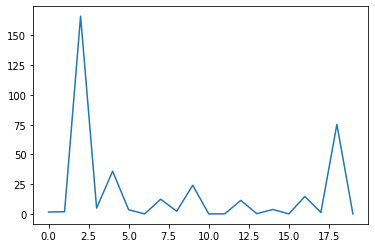

In [158]:
net = LSTM(200, 200, vocab_size, n_classes)

def train():
    
    criterion = nn.NLLLoss()

    optimizer = optim.Adam(net.parameters(), lr=0.01)

    epoch = 20

    start_time = time.time()

    loss_list = []

    for i in range(epoch):
        total_loss = 0.
        for j in range(len(x_train)):
            input, target = sentence2vector(x_train[i]), torch.tensor(y_train[i], dtype=torch.long)

            net.zero_grad()
            prob = net(input)
            loss = criterion(prob[-1].unsqueeze(0), target.unsqueeze(0))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 0.5)
            optimizer.step()

            total_loss += loss.item()
            log_interval = len(x_train)

            if j == len(x_train) - 1:
                time_past = time.time() - start_time
                cur_loss = total_loss
                loss_list.append(cur_loss)
                total_loss = 0
                print("epoch: ", i, "time: ", time_past , "loss: ", cur_loss)

    plt.plot(loss_list)

    plt.show()
    
train()

In [161]:
def test():
    count = 0
    with torch.no_grad():
        for i in range(len(x_val)):
            input, target = sentence2vector(x_val[i]), y_val[i]
            prob = net(input)
            #print(torch.argmax(prob[-1]).item(), target)
            if torch.argmax(prob[-1]).item() == target:
                count += 1
    print("acc_train: ", count / len(x_val))
    from collections import Counter
    distribution = Counter(y_val)
    print([i/len(y_val) for i in distribution.values()])


test()

acc_train:  0.2964824120603015
[0.6507537688442211, 0.16834170854271358, 0.02512562814070352, 0.12060301507537688, 0.035175879396984924]
